In [1]:
using Distributions
using HypothesisTests
using Random
using StatsBase: ecdf
using StatsPlots
default(fmt=:png, titlefontsize=10, tickfontsize=6,
    guidefontsize=9, plot_titlefontsize=10)

safediv(x, y) = x == 0 ? x : isinf(y) ? zero(y) : x/y

safediv (generic function with 1 method)

In [2]:
distname(dist) = replace(string(dist), r"{[^}]*}"=>"")

function distname(dist::LocationScale)
    μ, σ, ρ = params(dist)
    μ = round(μ; digits=3)
    σ = round(σ; digits=3)
    μ == 0 ? "$σ $(distname(ρ))" : "$μ + $σ $(distname(ρ))"
end

distname (generic function with 2 methods)

In [3]:
"""
    nextcombination!(n, t, c = typeof(t)[min(t-1, i) for i in 1:t])

`[1,2,…,n]` からの重複無しの `t` 個の組み合わせ `c` をすべて生成したい.

`nextcombination!(n, t, c)` は配列で表現された組み合わせ `c` をその次の組み合わせに書き換えて, `c` を返す.

初期条件を `c = typeof(t)[min(t-1, i) for i in 1:t]` にすると, `binomial(n, t)` 回の `nextcombination!(n, t, c)` ですべての組み合わせが生成される.
"""
function nextcombination!(n, t, c = typeof(t)[min(t-1, i) for i in 1:t])
    t == 0 && return c
    @inbounds for i in t:-1:1
        c[i] += 1
        c[i] > (n - (t - i)) && continue
        for j in i+1:t
            c[j] = c[j-1] + 1
        end
        break
    end
    c
end

"""
    mycombinations!(n::Integer, t, c)

事前に割り当てられた組み合わせを格納する配列 `c` を使って, `[1,2,…,n]` からの重複無しの `t` 個の組み合わせのすべてを生成する生成子を返す.
"""
function mycombinations!(n::Integer, t, c)
    for i in 1:t c[i] = min(t - 1, i) end
    (nextcombination!(n, t, c) for _ in 1:binomial(n, t))
end

"""
    mycombinations!(a, t, c)

事前に割り当てられた組み合わせを格納する配列 `c` を使って, 配列 `a` からのインデックスに重複がない `t` 個の組み合わせのすべてを生成する生成子を返す.
"""
function mycombinations!(a, t, c)
    t < 0 && (t = length(a) + 1)
    (view(a, indices) for indices in mycombinations!(length(a), t, c))
end

"""
    mycombinations(x, t)

`x` が整数ならば `[1,2,…,x]` からの, `x` が配列ならば `x` からのインデックスに重複がない `t` 個の組み合わせのすべてを生成する生成子を返す.
"""
mycombinations(x, t) = mycombinations!(x, t, Vector{typeof(t)}(undef, t))

mycombinations

In [4]:
using StatsBase: _tiedrank!

"""
    mytiedrank(X,
        rank = similar(X, Float64),
        place = similar(X, Int))

配列 `X` 内の値の順位(下から何番目に大きいか)を計算する.

値に重複がある場合には同順位にするために順位の平均を順位として採用する.

`rank`, `place` は内部で使う配列で, 事前に割り当てておけば, この函数はメモリ割り当てゼロで実行される.  `rank` が返り値になる.
"""
function mytiedrank(X,
        rank = similar(X, Float64),
        place = similar(X, Int))
    # Xの要素が整数ならば sortperm(X) を使った方がずっと速い.
    # そうなる理由は sortperm は sort! と違って sortperm_int_range も使用するから.
    # その代わりに sortperm だとメモリ割り当てが発生する.
    # この辺は Base 自体に改善の余地が残っているように思われる.
    #place = sortperm(X)
    place .= axes(place, 1)
    sort!(place; by = i -> @inbounds(X[i]))
    _tiedrank!(rank, X, place)
end

mytiedrank

In [5]:
"""
    exact_mann_whitney_u(x, y,
        xy = Vector{promote_type(eltype(x), eltype(y))}(undef, length(x)+length(y)),
        rankxy = similar(xy, Float64),
        place = similar(xy, Int),
        c = similar(x, Int, min(length(x), length(y)))
    )

データ `x, y` に関するMann-WhitneyのU検定のexact版を素朴なアルゴリズム(遅い)で実行し, `(u, u_less, u_greater, p_twosided, p_less, p_greater)` を返す.  ここで,

* `u` は `x`, `y` の `length` が小さい方のU統計量達.
* `u_less`, `u_greater` はそれぞれ `u`, `length(x)*length(y) - u` の小さい方と大きい方.
* `p_twosided` は両側検定のP値.
* `p_less` は `u_less` 以下になる確率.
* `p_greater` は `u_greater` 以上になる確率.

`p_twosided` は `p_less + p_greater` と1の小さい方になる.

`xy`, `rankxy`, `place`, `comb` は内部で使用する配列である. それらを事前に割り当てておけば, この函数はメモリ割り当てゼロで実行される.

この函数の実装では素朴にすべての組み合わせに関する和を計算する方法を採用しているので, `x`, `y` のサイズが大きくなると極めて遅くなる.  より洗練されたアルゴリズムについては以下の文献を参照せよ.

* https://pure.tue.nl/ws/files/1330412/200012964.pdf
* https://www.sciencedirect.com/science/article/pii/S1672022916000358

注意: この函数が返す両側検定のP値はR言語の [exactRankTests::wilcox.exact](https://rdrr.io/cran/exactRankTests/src/R/wilcox.exact.R) や [coin::wilcox_test](https://rdrr.io/cran/coin/src/R/LocationTests.R) と同じ値になる.  それらは素朴な実装を採用しているこの函数よりも計算が速い.

注意: この函数が返す両側検定のP値は [HypothesisTests.jl](https://github.com/JuliaStats/HypothesisTests.jl) の `pvalue(ExactMannWhitneyUTest(x, y))` とは一般に異なる.  そうなる理由は HypothesisTests.jl が `[x; y]` 内の値に重複(tie)がある場合に分布の左右対称性が崩れることに配慮していないからである.  さらに現時点の HypothesisTests.jl (v0.10.10) の `pvalue(ExactMannWhitneyUTest(x, y))` ではメモリ割り当てがかなり発生する.

注意: この函数が返す両側検定のP値は [scipy.stats.mannwhitneyu](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.mannwhitneyu.html) とは一般に異なる.  その理由は仕様的に "No correction is made for ties." となっているからである.
"""
function exact_mann_whitney_u(x, y,
        xy = Vector{promote_type(eltype(x), eltype(y))}(undef, length(x)+length(y)),
        rankxy = similar(xy, Float64),
        place = similar(xy, Int),
        comb = similar(x, Int, min(length(x), length(y)))
    )
    # Assume length(x) ≤ length(y)
    if length(x) > length(y)
        return exact_mann_whitney_u(y, x, xy, rankxy, place, comb)
    end
    
    # Initialization
    m, n = length(x), length(y)
    xy[1:m] .= x
    xy[m+1:m+n] .= y

    # Calculation of ranks
    rankxy = mytiedrank(xy, rankxy, place)
    
    # Calculation of P-values
    r = sum(@view rankxy[1:m]) # rank sum of the data x,y
    r_less, r_greater = minmax(r, m*(m+n+1) - r)
    num_less, num_greater = 0, 0
    for c in mycombinations!(rankxy, m, comb)
        R = sum(c) # rank sum of the combination c
        num_less    += R ≤ r_less
        num_greater += R ≥ r_greater
    end
    p_less, p_greater = (num_less, num_greater) ./ binomial(m+n, m)
    p_twosided = min(1, p_less + p_greater)
    
    # Calculation of U-statistics
    u, u_less, u_greater = (r, r_less, r_greater) .- m*(m+1)÷2
    
    # Returns
    u, u_less, u_greater, p_twosided, p_less, p_greater
end

@doc exact_mann_whitney_u

```
exact_mann_whitney_u(x, y,
    xy = Vector{promote_type(eltype(x), eltype(y))}(undef, length(x)+length(y)),
    rankxy = similar(xy, Float64),
    place = similar(xy, Int),
    c = similar(x, Int, min(length(x), length(y)))
)
```

データ `x, y` に関するMann-WhitneyのU検定のexact版を素朴なアルゴリズム(遅い)で実行し, `(u, u_less, u_greater, p_twosided, p_less, p_greater)` を返す.  ここで,

  * `u` は `x`, `y` の `length` が小さい方のU統計量達.
  * `u_less`, `u_greater` はそれぞれ `u`, `length(x)*length(y) - u` の小さい方と大きい方.
  * `p_twosided` は両側検定のP値.
  * `p_less` は `u_less` 以下になる確率.
  * `p_greater` は `u_greater` 以上になる確率.

`p_twosided` は `p_less + p_greater` と1の小さい方になる.

`xy`, `rankxy`, `place`, `comb` は内部で使用する配列である. それらを事前に割り当てておけば, この函数はメモリ割り当てゼロで実行される.

この函数の実装では素朴にすべての組み合わせに関する和を計算する方法を採用しているので, `x`, `y` のサイズが大きくなると極めて遅くなる.  より洗練されたアルゴリズムについては以下の文献を参照せよ.

  * https://pure.tue.nl/ws/files/1330412/200012964.pdf
  * https://www.sciencedirect.com/science/article/pii/S1672022916000358

注意: この函数が返す両側検定のP値はR言語の [exactRankTests::wilcox.exact](https://rdrr.io/cran/exactRankTests/src/R/wilcox.exact.R) や [coin::wilcox_test](https://rdrr.io/cran/coin/src/R/LocationTests.R) と同じ値になる.  それらは素朴な実装を採用しているこの函数よりも計算が速い.

注意: この函数が返す両側検定のP値は [HypothesisTests.jl](https://github.com/JuliaStats/HypothesisTests.jl) の `pvalue(ExactMannWhitneyUTest(x, y))` とは一般に異なる.  そうなる理由は HypothesisTests.jl が `[x; y]` 内の値に重複(tie)がある場合に分布の左右対称性が崩れることに配慮していないからである.  さらに現時点の HypothesisTests.jl (v0.10.10) の `pvalue(ExactMannWhitneyUTest(x, y))` ではメモリ割り当てがかなり発生する.

注意: この函数が返す両側検定のP値は [scipy.stats.mannwhitneyu](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.mannwhitneyu.html) とは一般に異なる.  その理由は仕様的に "No correction is made for ties." となっているからである.


In [6]:
"""
    h_brunner_munzel(x, y)

この函数は, x < y のとき 1.0 を, x = y のとき 0.5 を返す.
"""
h_brunner_munzel(x, y) = (x < y) + (x == y)/2

@doc raw"""
    phat_brunner_munzel(X, Y)

まず以下のようにおく:

```math
\begin{aligned}
&
H(x, y) = \begin{cases} 1 & (x < y) \\ 1/2 & (x = y), \end{cases}
\\ &
m = \mathrm{length}(X), \quad
n = \mathrm{length}(Y), \quad
x_i = X[i], \quad
y_j = Y[j]
\end{aligned}
```

この函数は次の $\hat{p}$ を返す:

```math
\hat{p} = \frac{1}{mn}\sum_{i=1}^m \sum_{j=1}^n H(x_i, y_j).
```
"""
phat_brunner_munzel(X, Y) = mean(h_brunner_munzel(x, y) for x in X, y in Y)

@doc raw"""
    statistics_brunner_munzel(X, Y,
        Hx = similar(X, Float64),
        Hy = similar(Y, Float64);
        p = 1/2
    )

この函数はデータ `X`, `Y` について, Brunner-Munzel検定関係の統計量達を計算する. 詳細は以下の通り.

函数 $H(x, y)$ と $\hat{p}$, $H^x_i$, $H^y_j$, $\bar{H}^x$, $\bar{H}^y$ を次のように定める:

```math
\begin{aligned}
&
m = \mathrm{length}(X), \quad
n = \mathrm{length}(Y), \quad
x_i = X[i], \quad
y_j = Y[j],
\\ &
\hat{p} = \frac{1}{mn}\sum_{i=1}^m \sum_{j=1}^n H(x_i, y_j),
\\ &
H(x, y) = \begin{cases} 1 & (x < y) \\ 1/2 & (x = y), \end{cases}
\\ &
H^x_i = \sum_{j=1}^n H(y_j, x_i), \quad
H^y_j = \sum_{i=1}^m H(x_i, y_j),
\\ &
\bar{H}^x = \frac{1}{m} \sum_{i=1}^m H^x_i = n - n\hat{p},
\\ &
\bar{H}^y = \frac{1}{n} \sum_{j=1}^n H^y_j = m\hat{p}.
\end{aligned}
```

この函数は以下達の named tuple で返す:

```math
\begin{aligned}
&
\mathrm{phat} = 
\hat{p} = \frac{\bar{H}^x - \bar{H}^y + n}{m + n},
\\ &
\mathrm{sx2} =
\hat{\sigma}_x^2 = \frac{1}{n^2}\frac{1}{m-1}\sum_{i=1}^m (H^x_i - \bar{H}^x)^2,
\\ &
\mathrm{sy2} =
\hat{\sigma}_y^2 = \frac{1}{m^2}\frac{1}{n-1}\sum_{j=1}^n (H^y_j - \bar{H}^y)^2,
\\ &
\mathrm{sehat} = 
\widehat{\mathrm{se}} = \sqrt{\frac{\hat{\sigma}_x^2}{m} + \frac{\hat{\sigma}_y^2}{n}}, 
\\ &
\mathrm{tvalue} = t = \frac{\hat{p} - p}{\widehat{\mathrm{se}}},
\\ &
\mathrm{df} =
\nu = 
\frac
{\left(\hat{\sigma}_x^2/m + \hat{\sigma}_y^2/n\right)^2}
{
\dfrac{\left(\hat{\sigma}_x^2/m\right)^2}{m-1} +
\dfrac{\left(\hat{\sigma}_y^2/n\right)^2}{n-1}
},
\\ &
\mathrm{pvalue} =
2\mathrm{ccdf}(\mathrm{TDist}(\nu), |t|).
\end{aligned}
```
"""
function statistics_brunner_munzel(X, Y,
        Hx = similar(X, Float64),
        Hy = similar(Y, Float64);
        p = 1/2
    )
    m, n = length(X), length(Y)
    for (i, x) in pairs(X)
        Hx[i] = sum(h_brunner_munzel(y, x) for y in Y)
    end
    for (j, y) in pairs(Y)
        Hy[j] = sum(h_brunner_munzel(x, y) for x in X)
    end
    phat = (mean(Hy) - mean(Hx) + n)/(m + n)
    sx2, sy2 = var(Hx)/n^2, var(Hy)/m^2
    sehat = √(sx2/m + sy2/n)
    tvalue = (phat - p)/sehat
    df = safediv((sx2/m + sy2/n)^2, (sx2/m)^2/(m-1) + (sy2/n)^2/(n-1))
    pvalue = (df != 0 && isfinite(df)) ? 2ccdf(TDist(df), abs(tvalue)) : zero(df)
    (; phat, sx2, sy2, sehat, tvalue, df, pvalue)
end

@doc raw"""
    pvalue_brunner_munzel(X, Y,
        Hx = similar(X, Float64),
        Hy = similar(Y, Float64);
        p = 1/2
    )

この函数はBrunner-Munzel検定のP値 `pvalue` を返す.
"""
function pvalue_brunner_munzel(X, Y,
        Hx = similar(X, Float64),
        Hy = similar(Y, Float64);
        p = 1/2
    )
    statistics_brunner_munzel(X, Y, Hx, Hy; p).pvalue
end

"""
    tieshift(X::AbstractVector, Y::AbstractVector; p = 1/2)

この函数は `phat_brunner_munzel(X, Y .+ a)` の値が `p` に等しくなる `a` を返す.
"""
function tieshift(X::AbstractVector, Y::AbstractVector; p = 1/2)
    shiftmin = minimum(X) - maximum(Y) - 0.1
    shiftmax = maximum(X) - minimum(Y) + 0.1
    find_zero(a -> phat_brunner_munzel(X, Y .+ a) - p, (shiftmin, shiftmax))
end

@doc raw"""
    brunner_munzel(X, Y,
        Hx = similar(X, Float64),
        Hy = similar(Y, Float64),
        Ytmp = similar(Y, Float64);
        p = 1/2,
        α = 0.05,
        maxsplit = 30
    )

この函数はBrunner-Munzel検定を実行する. 詳細は以下の通り.

この函数は `phat`, `sehat`, `tvalue`, `df`, `p`, `pvalue`, `α` および\
以下達の named tuple を返す.

```math
\begin{aligned}
&
\mathrm{confint\_p} = (\text{$p$ の信頼度 $1-\alpha$ の信頼区間}),
\\ &
\mathrm{confint\_shift} = (\text{2つの集団が互角になるようなシフトの信頼度 $1-\alpha$ の信頼区間}),
\\ &
\mathrm{pvalue\_shift} = ($\mathrm{confint\_shift}$ の計算で使われたP値函数),
\\ &
\mathrm{shifthat} = (\text{2つの集団が互角になるようなシフトの点推定値}).
\end{aligned}
```

さらに, $\mathrm{shiftmin}$, $\mathrm{shiftmax}$ はデータから推定されるシフトの下限と上限.

"""
function brunner_munzel(X, Y,
        Hx = similar(X, Float64),
        Hy = similar(Y, Float64),
        Ytmp = similar(Y, Float64);
        p = 1/2,
        α = 0.05,
        maxsplit = 30
    )
    (; phat, sehat, tvalue, df, pvalue) = statistics_brunner_munzel(X, Y, Hx, Hy; p)
    
    c = df == 0 ? Inf : quantile(TDist(df), 1 - α/2)
    confint_p = [max(0, phat - c*sehat), min(1, phat + c*sehat)]
    
    function pvalue_shift(a)
        @. Ytmp = Y + a
        pvalue_brunner_munzel(X, Ytmp, Hx, Hy; p)
    end
    shiftmin = minimum(X) - maximum(Y) - 0.1
    shiftmax = maximum(X) - minimum(Y) + 0.1
    shifthat = tieshift(X, Y; p)
    confint_shift = [
        find_zero(a -> pvalue_shift(a) - α, (shiftmin, shifthat))
        find_zero(a -> pvalue_shift(a) - α, (shifthat, shiftmax))
    ]
    
    (; phat, sehat, tvalue, df, p, pvalue, α, confint_p,
        confint_shift, pvalue_shift, shifthat, shiftmin, shiftmax)
end

function show_plot_brunner_munzel(X, Y,
        Hx = similar(X, Float64),
        Hy = similar(Y, Float64),
        Ytmp = similar(Y, Float64);
        p = 1/2,
        α = 0.05,
        showXY = false,
        kwargs...
    )
    showXY && (@show X Y)
    (; phat, sehat, tvalue, df, p, pvalue, α, confint_p, 
        confint_shift, pvalue_shift, shifthat, shiftmin, shiftmax) =
        brunner_munzel(X, Y, Hx, Hy, Ytmp; p, α)
    pprint((; phat, sehat, tvalue, df, p, pvalue, α, confint_p,
            confint_shift, shifthat))
    println()
    @show median(X) median(Y)
    plot(pvalue_shift, shiftmin, shiftmax; label="")
    vline!([tieshift(X, Y)]; label="", ls=:dash)    
    title!("P-value function of shift")
    plot!(ytick=0:0.05:1)
    plot!(; kwargs...)
end

show_plot_brunner_munzel (generic function with 4 methods)

In [7]:
function sim(;
        distx = Normal(50, 1),
        disty = Normal(50, 1),
        m = 5,
        n = 5,
        L = 10^5,
        calc_bm = false
    )
    tmpx = [Vector{Float64}(undef, m) for _ in 1:Threads.nthreads()]
    tmpy = [Vector{Float64}(undef, n) for _ in 1:Threads.nthreads()]
    if calc_bm
        tmpHx = [Vector{Float64}(undef, m) for _ in 1:Threads.nthreads()]
        tmpHy = [Vector{Float64}(undef, n) for _ in 1:Threads.nthreads()]
        tmpYtmp = [Vector{Float64}(undef, n) for _ in 1:Threads.nthreads()]
        pval_bm = Vector{Float64}(undef, L)
    else
        tmpxy = [Vector{Float64}(undef, m+n) for _ in 1:Threads.nthreads()]
        tmprankxy = [Vector{Float64}(undef, m+n) for _ in 1:Threads.nthreads()]
        tmpplace = [Vector{Int}(undef, m+n) for _ in 1:Threads.nthreads()]
        tmpcomb = [Vector{Int}(undef, min(m,n)) for _ in 1:Threads.nthreads()]
        pval_ewmw = Vector{Float64}(undef, L)
    end
    pval_awmw = Vector{Float64}(undef, L)
    Threads.@threads for i in 1:L
        x = rand!(distx, tmpx[Threads.threadid()])
        y = rand!(disty, tmpy[Threads.threadid()])
        if calc_bm
            pval_bm[i] = pvalue_brunner_munzel(x, y,
                tmpHx[Threads.threadid()],
                tmpHy[Threads.threadid()])
        else
            result_ewmw = exact_mann_whitney_u(x, y,
                tmpxy[Threads.threadid()],
                tmprankxy[Threads.threadid()],
                tmpplace[Threads.threadid()],
                tmpcomb[Threads.threadid()])
            pval_ewmw[i] = result_ewmw[4]
        end
        result_amwm = ApproximateMannWhitneyUTest(x, y)
        pval_awmw[i] = pvalue(result_amwm)
    end
    if calc_bm
        pval_bm, pval_awmw
    else
        pval_ewmw, pval_awmw
    end
end

sim (generic function with 1 method)

## 等分布の場合

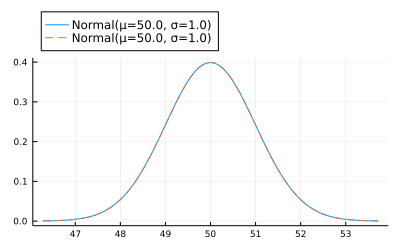

  3.915493 seconds (14.98 M allocations: 1.007 GiB, 5.59% gc time, 40.98% compilation time: 2% of which was recompilation)


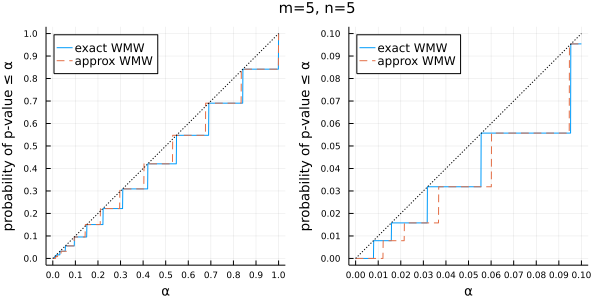

In [8]:
Random.seed!(4649373)
m, n = 5, 5
distx, disty = Normal(50, 1), Normal(50, 1)
plot(distx; label=distname(distx))
plot!(disty; label=distname(disty), ls=:dash)
plot!(size=(400, 250), legend=:outertop) |> display

pval_ewmw, pval_awmw = @time sim(; distx, disty, m, n, L=10^6)
ecdf_ewmw = ecdf(pval_ewmw)
f(x) = ecdf_ewmw(x)
ecdf_awmw = ecdf(pval_awmw)
g(x) = ecdf_awmw(x)

xmax = 1
tick = 0:xmax/10:xmax
x = 0:xmax/1000:xmax
P1 = plot(legend=:topleft)
plot!(x, f; label="exact WMW")
plot!(x, g; label="approx WMW", ls=:dash)
plot!([0, xmax], [0, xmax]; label="", c=:black, ls=:dot)
plot!(xtick=tick, ytick=tick)
plot!(xguide="α", yguide="probability of p-value ≤ α")

xmax = 0.1
tick = 0:xmax/10:1
x = 0:xmax/1000:xmax
P2 = plot(legend=:topleft)
plot!(x, f; label="exact WMW")
plot!(x, g; label="approx WMW", ls=:dash)
plot!([0, xmax], [0, xmax]; label="", c=:black, ls=:dot)
plot!(xtick=tick, ytick=tick)
plot!(xguide="α", yguide="probability of p-value ≤ α")

plot(P1, P2; size=(600, 300))
plot!(plot_title="m=$m, n=$n")

上のグラフはP値のecdf (経験累積分布函数)のプロットである.

以下の2つのプロットを比較すればわかるように, ヒストグラムはビンの取り方で大幅に印象が変わるので要注意である.

統計学入門の講義では「ヒストグラムは印象操作に悪用できるので要注意である」と教える必要がある.

ヒストグラムの代わりにecdf (経験累積分布函数)のグラフやQQプロットの類を使った方がよい場合は多い.

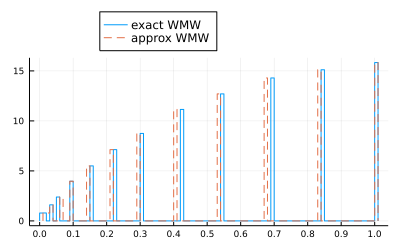

In [9]:
xmax = 1
tick = 0:xmax/10:xmax
bin = :auto
P1 = plot(legend=:outertop)
stephist!(pval_ewmw; norm=true, bin, label="exact WMW")
stephist!(pval_awmw; norm=true, bin, label="approx WMW", ls=:dash)
plot!(xtick=tick, size=(400, 250))

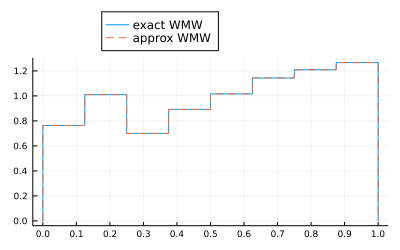

In [10]:
xmax = 1
tick = 0:xmax/10:xmax
bin = 0:(xmax+eps())/8:xmax+eps()
P1 = plot(legend=:outertop)
stephist!(pval_ewmw; norm=true, bin, label="exact WMW")
stephist!(pval_awmw; norm=true, bin, label="approx WMW", ls=:dash)
plot!(xtick=tick, size=(400, 250))

## Brunner-Munzel と Wilcoxon-Mann-Whitney の比較

In [11]:
function plot_bm_vs_wmw(; distx=Normal(), disty=Normal(), m=50, n=50, kwargs...)
    plot(distx; label=distname(distx))
    plot!(disty; label=distname(disty), ls=:dash)
    plot!(size=(400, 250), legend=:outertop)
    plot!(; kwargs...) |> display

    @show mean(distx), std(distx)
    @show mean(disty), std(disty)
    
    pval_bm, pval_awmw = @time sim(; distx, disty, m, n, L=10^5, calc_bm=true)
    ecdf_bm = ecdf(pval_bm)
    f(x) = ecdf_bm(x)
    ecdf_awmw = ecdf(pval_awmw)
    g(x) = ecdf_awmw(x)

    xmax = 1
    tick = 0:xmax/10:xmax
    x = 0:xmax/1000:xmax
    P1 = plot(legend=:topleft)
    plot!(x, f; label="Brunner-Munzel", c=1)
    plot!(x, g; label="approx WMW", ls=:dash, c=2)
    plot!([0, xmax], [0, xmax]; label="", c=:black, ls=:dot)
    plot!(xtick=tick, ytick=tick)
    plot!(xguide="α", yguide="probability of p-value ≤ α")

    xmax = 0.1
    tick = 0:xmax/10:1
    x = 0:xmax/1000:xmax
    P2 = plot(legend=:topleft)
    plot!(x, f; label="Brunner-Munzel", c=1)
    plot!(x, g; label="approx WMW", ls=:dash, c=2)
    plot!([0, xmax], [0, xmax]; label="", c=:black, ls=:dot)
    plot!(xtick=tick, ytick=tick)
    plot!(xguide="α", yguide="probability of p-value ≤ α")

    plot(P1, P2; size=(600, 300))
    plot!(plot_title="$(distname(distx)), m=$m vs. $(distname(disty)), n=$n")
end

plot_bm_vs_wmw (generic function with 1 method)

### 不等分散の場合

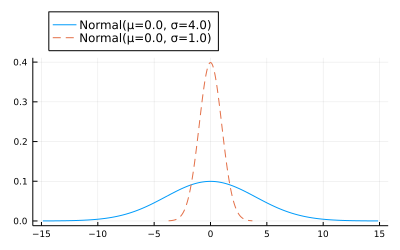

(mean(distx), std(distx)) = (0.0, 4.0)
(mean(disty), std(disty)) = (0.0, 1.0)
  0.244900 seconds (877.71 k allocations: 361.159 MiB, 29.04% compilation time)


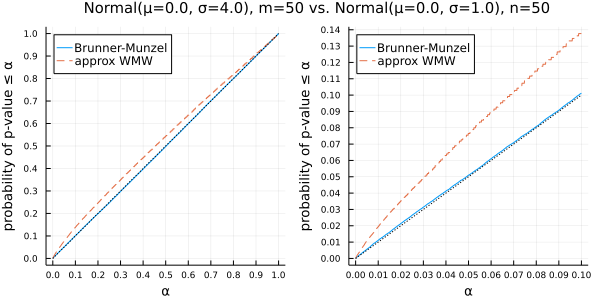

In [12]:
plot_bm_vs_wmw(; distx=Normal(0,4), disty=Normal(), m=50, n=50)

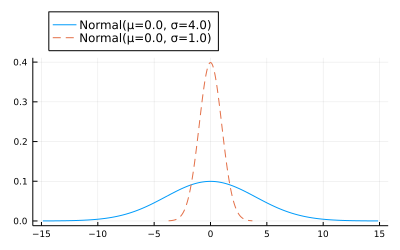

(mean(distx), std(distx)) = (0.0, 4.0)
(mean(disty), std(disty)) = (0.0, 1.0)
  0.475536 seconds (799.74 k allocations: 528.007 MiB, 39.58% gc time)


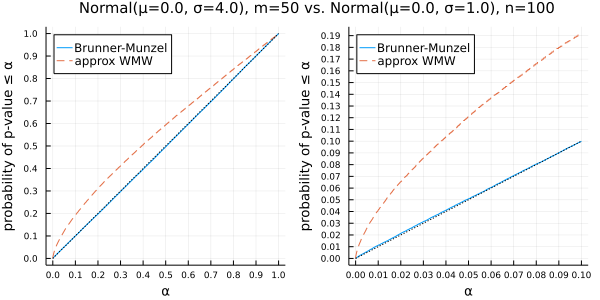

In [13]:
plot_bm_vs_wmw(; distx=Normal(0,4), disty=Normal(), m=50, n=100)

## 等分散かつ不等分布の場合

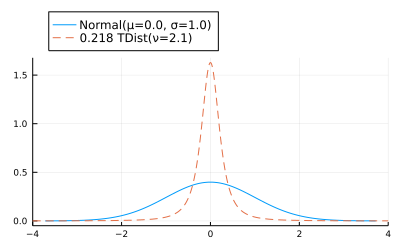

(mean(distx), std(distx)) = (0.0, 1.0)
(mean(disty), std(disty)) = (0.0, 1.0)
  0.372391 seconds (1.18 M allocations: 376.223 MiB, 45.94% compilation time)


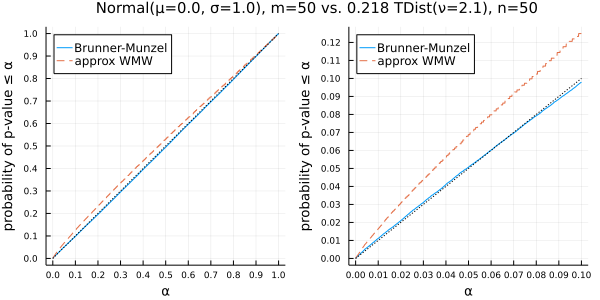

In [14]:
ν = 2.1
plot_bm_vs_wmw(; distx=Normal(), disty=√((ν-2)/ν)*TDist(ν), m=50, n=50, xlim=(-4, 4))

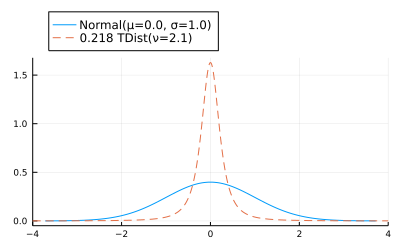

(mean(distx), std(distx)) = (0.0, 1.0)
(mean(disty), std(disty)) = (0.0, 1.0)
  0.540435 seconds (799.74 k allocations: 528.007 MiB, 30.60% gc time)


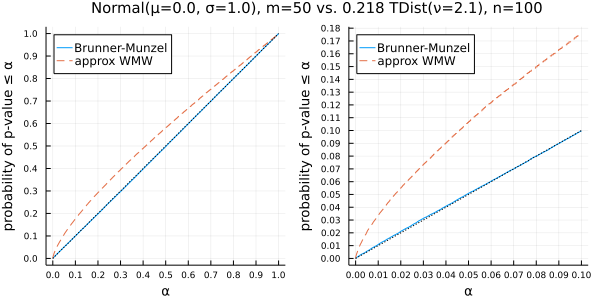

In [15]:
ν = 2.1
plot_bm_vs_wmw(; distx=Normal(), disty=√((ν-2)/ν)*TDist(ν), m=50, n=100, xlim=(-4, 4))

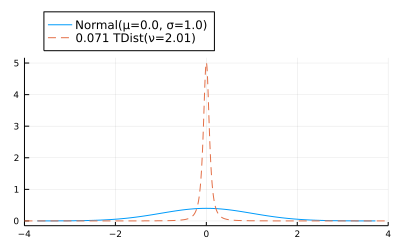

(mean(distx), std(distx)) = (0.0, 1.0)
(mean(disty), std(disty)) = (0.0, 1.0)
  0.210171 seconds (799.74 k allocations: 357.095 MiB)


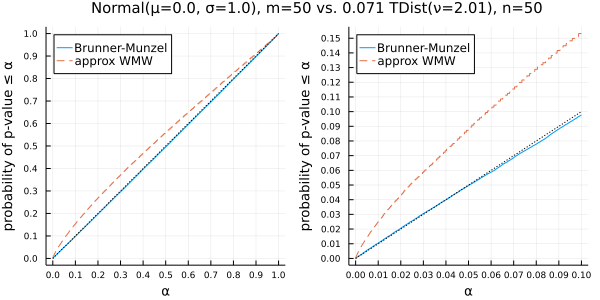

In [16]:
ν = 2.01
plot_bm_vs_wmw(; distx=Normal(), disty=√((ν-2)/ν)*TDist(ν), m=50, n=50, xlim=(-4, 4))

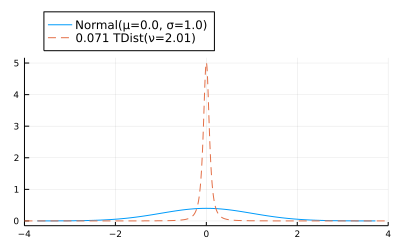

(mean(distx), std(distx)) = (0.0, 1.0)
(mean(disty), std(disty)) = (0.0, 1.0)
  0.592343 seconds (799.75 k allocations: 528.008 MiB, 39.74% gc time)


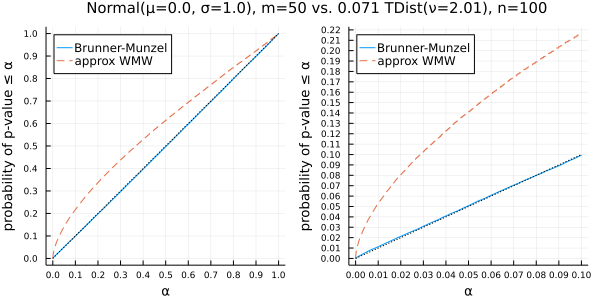

In [17]:
ν = 2.01
plot_bm_vs_wmw(; distx=Normal(), disty=√((ν-2)/ν)*TDist(ν), m=50, n=100, xlim=(-4, 4))